In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("/Users/cesare.chung/Downloads/train.csv", index_col="Loan_ID")


In [2]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
data.shape

(614, 12)

In [4]:
#1 – Boolean Indexing
# We want a list of all females who are not graduate and got a loan

data.loc[(data["Gender"]=="Female") & (data["Education"]=="Not Graduate") & (data["Loan_Status"]=="Y"), ["Gender","Education","Loan_Status"]]

,Gender,Education,Loan_Status
Loan_ID,,,
LP001155,Female,Not Graduate,Y
LP001669,Female,Not Graduate,Y
LP001692,Female,Not Graduate,Y
LP001908,Female,Not Graduate,Y
LP002300,Female,Not Graduate,Y
LP002314,Female,Not Graduate,Y
LP002407,Female,Not Graduate,Y
LP002489,Female,Not Graduate,Y
LP002502,Female,Not Graduate,Y


In [5]:
#2 – Apply Function
#Create a new function:
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print ("Missing values per column:")
print (data.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column

#Applying per row:
print ("\nMissing values per row:")
print (data.apply(num_missing, axis=1).head()) #axis=1 defines that function is to be applied on each row

Missing values per column:
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Missing values per row:
Loan_ID
LP001002    1
LP001003    0
LP001005    0
LP001006    0
LP001008    0
dtype: int64


In [6]:
#3 – Imputing missing files
#First we import a function to determine the mode
from scipy.stats import mode
#mode(data["Gender"])
mode(data["Gender"].dropna())


/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


ModeResult(mode=array(['Male'], dtype=object), count=array([489]))

In [7]:
mode(data['Gender'].dropna()).mode[0]


/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


'Male'

In [8]:
#Impute the values:
data['Gender'].fillna(mode(data['Gender'].dropna()).mode[0], inplace=True)
data['Married'].fillna(mode(data['Married'].dropna()).mode[0], inplace=True)
data['Self_Employed'].fillna(mode(data['Self_Employed'].dropna()).mode[0], inplace=True)

#Now check the #missing values again to confirm:
print ("Missing values per column:")
print (data.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column


Missing values per column:
Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


/anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [9]:
#4 – Pivot Table

#Determine pivot table
impute_grps = data.pivot_table(values=["LoanAmount"], index=["Gender","Married","Self_Employed"], aggfunc=np.mean)
print (impute_grps)


                              LoanAmount
Gender Married Self_Employed            
Female No      No             114.691176
               Yes            125.800000
       Yes     No             134.222222
               Yes            282.250000
Male   No      No             129.936937
               Yes            180.588235
       Yes     No             153.882736
               Yes            169.395833


In [10]:
#5 – Multi-Indexing

#iterate only through rows with missing LoanAmount
for i,row in data.loc[data['LoanAmount'].isnull(),:].iterrows():
  ind = tuple([row['Gender'],row['Married'],row['Self_Employed']])
  data.loc[i,'LoanAmount'] = impute_grps.loc[ind].values[0]

#Now check the #missing values again to confirm:
print (data.apply(num_missing, axis=0))

Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [11]:
#6. Crosstab
pd.crosstab(data["Credit_History"],data["Loan_Status"],margins=True)


Loan_Status,N,Y,All
Credit_History,,,
0.0,82,7,89
1.0,97,378,475
All,179,385,564


In [12]:
#7 – Merge DataFrames

prop_rates = pd.DataFrame([1000, 5000, 12000], index=['Rural','Semiurban','Urban'],columns=['rates'])
prop_rates

,rates
Rural,1000
Semiurban,5000
Urban,12000


In [13]:
data_merged = data.merge(right=prop_rates, how='inner',left_on='Property_Area',right_index=True, sort=False)
data_merged.pivot_table(values='Credit_History',index=['Property_Area','rates'], aggfunc=len)

,,Credit_History
Property_Area,rates,
Rural,1000,179.0
Semiurban,5000,233.0
Urban,12000,202.0


In [14]:
#8 – Sorting DataFrames

data_sorted = data.sort_values(['ApplicantIncome','CoapplicantIncome'], ascending=False)
data_sorted[['ApplicantIncome','CoapplicantIncome']].head(10)

,ApplicantIncome,CoapplicantIncome
Loan_ID,,
LP002317,81000,0.0
LP002101,63337,0.0
LP001585,51763,0.0
LP001536,39999,0.0
LP001640,39147,4750.0
LP002422,37719,0.0
LP001637,33846,0.0
LP001448,23803,0.0
LP002624,20833,6667.0


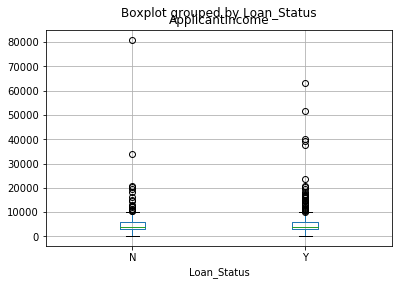

In [15]:
#9 – Plotting (Boxplot & Histogram)


import matplotlib.pyplot as plt
%matplotlib inline
data.boxplot(column="ApplicantIncome",by="Loan_Status")


array([<matplotlib.axes._subplots.AxesSubplot object at 0x111724940>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1116d0320>], dtype=object)

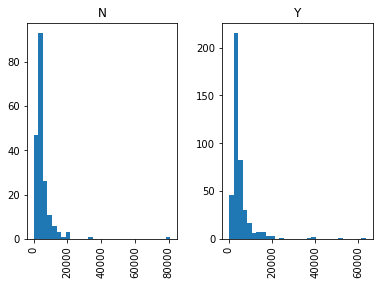

In [16]:
data.hist(column="ApplicantIncome",by="Loan_Status",bins=30)


In [17]:
#10 – Cut function for binning

#Binning:
def binning(col, cut_points, labels=None):
  #Define min and max values:
  minval = col.min()
  maxval = col.max()

  #create list by adding min and max to cut_points
  break_points = [minval] + cut_points + [maxval]

  #if no labels provided, use default labels 0 ... (n-1)
  if not labels:
    labels = range(len(cut_points)+1)

  #Binning using cut function of pandas
  colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
  return colBin

#Binning age:
cut_points = [90,140,190]
labels = ["low","medium","high","very high"]
data["LoanAmount_Bin"] = binning(data["LoanAmount"], cut_points, labels)
print (pd.value_counts(data["LoanAmount_Bin"], sort=False))

high         146
low          104
medium       273
very high     91
Name: LoanAmount_Bin, dtype: int64


In [18]:
#11 – Coding nominal data

#Define a generic function using Pandas replace function
def coding(col, codeDict):
  colCoded = pd.Series(col, copy=True)
  for key, value in codeDict.items():
    colCoded.replace(key, value, inplace=True)
  return colCoded
 
#Coding LoanStatus as Y=1, N=0:
print ('Before Coding:')
print (pd.value_counts(data["Loan_Status"]))
data["Loan_Status_Coded"] = coding(data["Loan_Status"], {'N':0,'Y':1})
print ('\nAfter Coding:')
print (pd.value_counts(data["Loan_Status_Coded"]))

Before Coding:
Y    422
N    192
Name: Loan_Status, dtype: int64

After Coding:
1    422
0    192
Name: Loan_Status_Coded, dtype: int64


In [19]:
#12 – Iterating over rows of a dataframe

#Check current type:
data.dtypes

Gender                 object
Married                object
Dependents             object
Education              object
Self_Employed          object
ApplicantIncome         int64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History        float64
Property_Area          object
Loan_Status            object
LoanAmount_Bin       category
Loan_Status_Coded       int64
dtype: object